## `step-1`: Load Preprocessed Data

- X_train
- X_val
- X_test
- y_train
- y_val
- y_test

In [7]:
# ========= Import Libraries =========
import numpy as np



In [8]:
X_train = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_train.npy', allow_pickle=True)
X_val = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_val.npy', allow_pickle=True)
X_test = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_test.npy', allow_pickle=True)
y_train = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_train.npy', allow_pickle=True)
y_val = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_val.npy', allow_pickle=True)
y_test = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_test.npy', allow_pickle=True)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2208, 224, 224, 3) (2208, 15)
(736, 224, 224, 3) (736, 15)
(737, 224, 224, 3) (737, 15)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

NUM_CLASSES = len(y_train[0])

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers, metrics

base_cnn = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_cnn.trainable = False  # freeze backbone initially

model = models.Sequential([
    base_cnn,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(521, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        metrics.AUC(name="auc", multi_label=True),
        metrics.AUC(name="auprc", curve="PR", multi_label=True),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall")
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 521)               534025    
                                                                 
 dropout_10 (Dropout)        (None, 521)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               133632    
                                                      

In [17]:
# ================== Callbacks ==================

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

In [18]:
# ================== Train ==================

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=callbacks
)


Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 1.0984 - auc: 0.5040 - auprc: 0.0806 - precision: 0.1743 - recall: 0.3745
Epoch 1: val_loss improved from inf to 0.30223, saving model to best_model.h5


c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 244s 3s/step - loss: 1.0984 - auc: 0.5040 - auprc: 0.0806 - precision: 0.1743 - recall: 0.3745 - val_loss: 0.3022 - val_auc: 0.5292 - val_auprc: 0.0944 - val_precision: 0.5834 - val_recall: 0.4780
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.5024 - auc: 0.5177 - auprc: 0.0842 - precision: 0.2954 - recall: 0.3411
Epoch 2: val_loss improved from 0.30223 to 0.23286, saving model to best_model.h5
69/69 [==============================] - 234s 3s/step - loss: 0.5024 - auc: 0.5177 - auprc: 0.0842 - precision: 0.2954 - recall: 0.3411 - val_loss: 0.2329 - val_auc: 0.5454 - val_auprc: 0.0955 - val_precision: 0.5830 - val_recall: 0.4802
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.4145 - auc: 0.5042 - auprc: 0.0852 - precision: 0.3065 - recall: 0.3482
Epoch 3: val_loss improved from 0.23286 to 0.21896, saving model to best_model.h5
69/69 [==============================] - 218s 3s/step - loss: 0.4145 - auc: 

#### Conclusion

- This is not yet a good model:

- AUC ~0.5–0.57 is basically close to random.

- AUPRC is barely better than the prevalence baseline.

- The network is mostly learning class imbalance bias (likely predicting negatives most of the time).

#### Suggestion

- Right now, your model is weak (random-level). To get meaningful results on multilabel imbalance (like chest X-rays), you need focal loss + class weights + fine-tuning the pretrained backbone.

In [20]:
# ================== Evaluate ==================
test_loss, test_auc, test_auprc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test AUPRC: {test_auprc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

24/24 [==============================] - 58s 2s/step - loss: 0.2255 - auc: 0.5292 - auprc: 0.0854 - precision: 0.5622 - recall: 0.4547
Test Loss: 0.2255
Test AUC: 0.5292
Test AUPRC: 0.0854
Test Precision: 0.5622
Test Recall: 0.4547


In [26]:
import joblib

mlb = joblib.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\multilabel_binarizer.pkl')

y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.3).astype(int) 

# Classification report
from sklearn.metrics import classification_report
print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_binary, target_names=mlb.classes_, zero_division=0))


 CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00        64
      Cardiomegaly       0.00      0.00      0.00        27
     Consolidation       0.00      0.00      0.00        27
             Edema       0.00      0.00      0.00         9
          Effusion       0.00      0.00      0.00        69
         Emphysema       0.00      0.00      0.00        15
          Fibrosis       0.00      0.00      0.00        30
           Healthy       0.56      1.00      0.72       416
            Hernia       0.00      0.00      0.00         3
      Infiltration       0.25      0.02      0.04       131
              Mass       0.00      0.00      0.00        15
            Nodule       0.00      0.00      0.00        39
Pleural_Thickening       0.00      0.00      0.00        24
         Pneumonia       0.00      0.00      0.00         8
      Pneumothorax       0.00      0.00      0.00        18

         micr

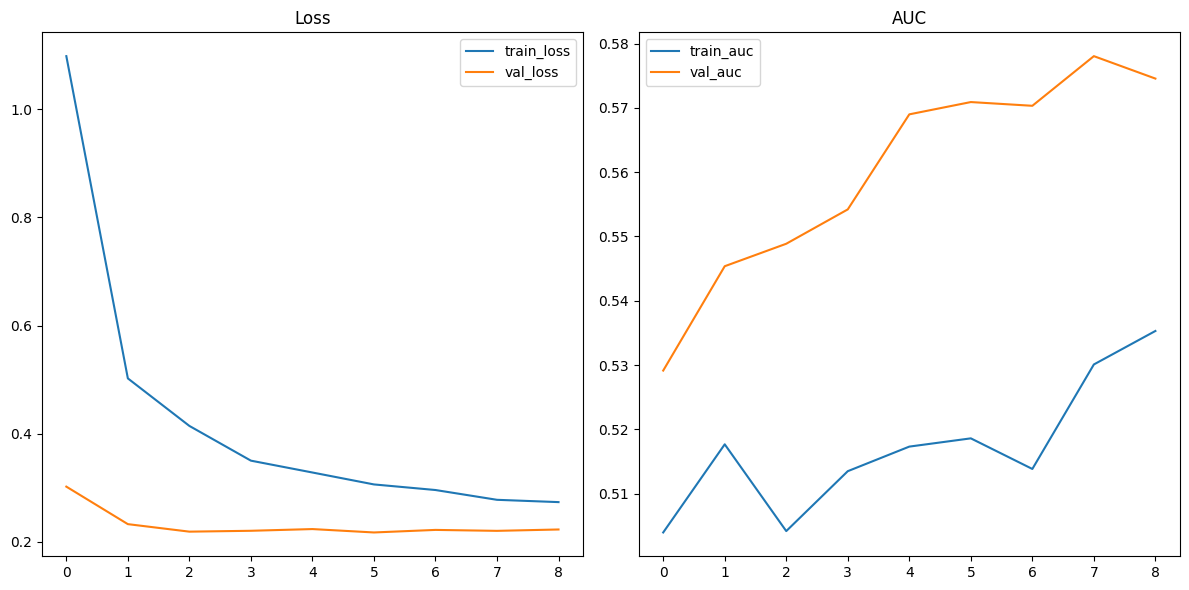

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Load history
history = np.load(
    r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\training_history.npy",
    allow_pickle=True
).item()

# ================== Plot Training Curves ==================
plt.figure(figsize=(12,6))

# Loss curves
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")

# AUC curves
plt.subplot(1,2,2)
plt.plot(history['auc'], label='train_auc')
plt.plot(history['val_auc'], label='val_auc')
plt.legend()
plt.title("AUC")

plt.tight_layout()

# Save first, then show
plt.savefig(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\curves\base_training_curves.png')
plt.show()


In [27]:
# Save the final model
model.save(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\base_model.h5')
print("💾 Model saved as 'chest_xray_final_model.h5'")

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


💾 Model saved as 'chest_xray_final_model.h5'


In [28]:

# Save training history
np.save(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\training_history.npy', history.history)
print("💾 Training history saved")

💾 Training history saved


## `Conclusion`

### What to Try Next

#### **Better Loss for Imbalance**
- Replace binary_crossentropy with Focal Loss

#### **Class Weights**
- Compute positive/negative frequency per class and pass class_weight in .fit(). This pushes the model to care more about rare diseases.

#### **Fine-tuning**
- After a few frozen-epoch warmups, unfreeze DenseNet121 layers and continue training at a lower LR (1e-5). This usually improves AUC drastically.

#### **Data Augmentation**
- Use heavy augmentation (ImageDataGenerator or tf.keras.layers) — flips, rotations, brightness — to improve generalization.

#### **Evaluation Metrics**
- Track per-class AUC instead of just overall AUC. Sometimes average looks poor but some classes do much better